In [1]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 784)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    script_dir=os.getcwd()
    rel_path="Input_data/"
    abs_path=os.path.join(script_dir,rel_path)
    X_train = load_mnist_images(abs_path+'train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels(abs_path+'train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images(abs_path+'t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels(abs_path+'t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [2]:
import numpy as np
import sys
import os
from matplotlib import pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test=load_dataset()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
indices_3_7=np.where((y_train==3) | (y_train==7))

In [4]:
X_train_3_7=X_train[indices_3_7,:]

In [5]:
X_train_3_7=X_train_3_7.reshape((10276,784))

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca=PCA(n_components=50)
pca_train=pca.fit(X_train_3_7)

In [8]:
PCA_vectors=pca.components_
PCA_vectors=np.transpose(np.array(PCA_vectors))

In [9]:
PCA_vectors.shape

(784, 50)

scores_trial=np.zeros(784)
for i in range(784):
    scores_trial[i]=np.linalg.norm(PCA_vectors[i,0:100])**2

top_features_trial=np.argsort(scores_trial)[::-1][:100]

In [11]:
from sklearn import svm
clf=svm.SVC(kernel='linear',decision_function_shape='ovr')
clf.fit(X_train_3_7,y_train[indices_3_7])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
indices_3_7_test=np.where((y_test==3) | (y_test==7))

In [16]:
X_test_3_7=X_test[indices_3_7_test,:,:]

In [17]:
X_test_3_7=X_test_3_7.reshape((2038,784))

In [159]:
y_test_3_7=y_test[indices_3_7_test]

In [160]:
clf.score(X_test_3_7,y_test_3_7)

0.9823356231599607

In [24]:
clf.decision_function(X_test_3_7[0,:])[0]

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


1.3449007671098265

In [25]:
y_test[indices_3_7_test][0]

7

In [26]:
w=clf.coef_

In [27]:
b=clf.intercept_

In [110]:
Y=np.dot(w,PCA_vectors).reshape((50,1))

In [111]:
Y.shape

(50, 1)

In [30]:
x=X_test_3_7[0,:]

In [31]:
np.dot(w,x)+b

array([ 1.34490077])

In [32]:
x_k=pca.transform(x)
x_tilde=pca.inverse_transform(x_k)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [33]:
x_tilde=x_tilde.reshape((784))

In [34]:
C=np.dot(w,x_tilde)+b

In [40]:
PCA_vectors_t=np.transpose(PCA_vectors)

In [41]:
PCA_vectors_t.shape

(50, 784)

### Optimal attack

In [36]:
import cvxpy as cvx

In [112]:
delta=cvx.Variable(784,1)

obj=cvx.Minimize(cvx.norm(delta))

cons=[cvx.norm(delta)<=1.0,cvx.sum_entries(cvx.mul_elemwise(Y,PCA_vectors_t*delta),axis=0)+C<-0.1]

prob=cvx.Problem(obj,cons)

prob.solve()

prob.status

Delta_curr=delta.value

Delta_curr=Delta_curr.reshape((784,1))

x=x.reshape((784,1))

x.shape

Delta_curr.shape

x_adv=(x+Delta_curr).reshape((784))

In [140]:
clf.decision_function(x_adv)

array([-0.32652295])

In [141]:
x_adv_k=pca.transform(x_adv)
x_adv_tilde=pca.inverse_transform(x_adv_k)

In [142]:
clf.decision_function(x_adv_tilde)

array([-0.09999798])

In [144]:
clf.predict(x_adv_tilde)

array([3], dtype=uint8)

In [76]:
cvx.sum_entries(cvx.mul_elemwise(Y,PCA_vectors_t*delta.value))+C

Expression(CONSTANT, UNKNOWN, (1, 1))

In [143]:
np.sum(np.multiply(Y,np.dot(PCA_vectors_t,Delta_curr)))+C

array([-0.1])

In [161]:
indices_7_test=np.where(y_test_3_7==7)

In [165]:
len(indices_7_test[0])

1028

In [162]:
max_eps=1.0
count_orig=0.0
count_recons=0.0
count_total=10.0
count=0.0
for i in indices_7_test[0]:
    x=X_test_3_7[i,:]
    delta=cvx.Variable(784,1)
    C=np.dot(w,x)+b
    obj=cvx.Minimize(cvx.norm(delta))
    cons=[cvx.norm(delta)<=max_eps,w*delta+C<0]
    prob=cvx.Problem(obj,cons)
    prob.solve()
#     print prob.status
    if prob.status=='optimal':
        Delta_curr=delta.value
        Delta_curr=Delta_curr.reshape((784,1))
        x=x.reshape((784,1))
        x_adv=(x+Delta_curr).reshape(1,-1)
        if clf.predict(x_adv)[0]!=7:
            count_orig=count_orig+1
        x_adv_k=pca.transform(x_adv)
        x_adv_tilde=pca.inverse_transform(x_adv_k)
        if clf.predict(x_adv_tilde)[0]!=7:
            count_recons=count_recons+1
        count=count+1
print count_orig/count, count_recons/count, count    

1.0 0.031158714703 1027.0


In [175]:
x.shape

(784,)

In [182]:
max_eps=1.0
count_orig=0.0
count_recons=0.0
count_total=10.0
count=0.0
for i in indices_7_test[0]:
    print i
    x=X_test_3_7[i,:]
    x=x.reshape((1,784))
    x_k=pca.transform(x)
    x_tilde=pca.inverse_transform(x_k)
    x_tilde=x_tilde.reshape(784)
    C=np.dot(w,x_tilde)+b
    delta=cvx.Variable(784,1)
    obj=cvx.Minimize(cvx.norm(delta))
    cons=[cvx.norm(delta)<=1.0,cvx.sum_entries(cvx.mul_elemwise(Y,PCA_vectors_t*delta),axis=0)+C<-0.01]
    prob=cvx.Problem(obj,cons)
    prob.solve(solver='CVXOPT')
#     print prob.status
    if prob.status=='optimal':
        Delta_curr=delta.value
        Delta_curr=Delta_curr.reshape((784,1))
        x=x.reshape((784,1))
        x_adv=(x+Delta_curr).reshape(1,-1)
        if clf.predict(x_adv)[0]!=7:
            count_orig=count_orig+1
        x_adv_k=pca.transform(x_adv)
        x_adv_tilde=pca.inverse_transform(x_adv_k)
        x_adv_tilde=x_adv_tilde.reshape(1,-1)
        if clf.predict(x_adv_tilde)[0]!=7:
            count_recons=count_recons+1
        count=count+1
print count_orig/count, count_recons/count, count    

0
1
3
6
7
8
11
13
15
16
18
19
20
21
25
26
28
29
30
31
32
34
36
38
44
45
46
49
50
52
53
54
55
57
58
59
64
67
70
72
75
78
79
80
81
83
90
91
93
97
99
105
106
107
108
115
116
119
121
122
124
127
128
130
131
132
134
136
138
141
143
144
145
146
148
150
153
154
162
166
167
168
169
170
171
174
175
177
179
184
185
186
188
192
195
197
198
201
204
206
207
209
211
213
218
220
223
225
226
228
230
231
232
233
236
238
239
241
242
244
246
247
248
249
252
255
256
258
259
260
262
264
272
273
274
275
276
278
279
280
281
282
284
287
288
294
299
301
302
303
304
306
307
310
311
314
315
316
317
318
319
320
321
325
326
330
337
339
341
345
346
347
348
349
350
351
355
357
360
361
365
366
367
369
370
372
375
378
379
380
381
387
389
390
391
393
395
397
400
401
402
403
404
407
408
414
416
418
421
423
424
425
427
434
435
436
439
440
442
444
445
448
450
451
452
453
457
458
459
460
461
463
464
465
466
467
471
473
475
480
481
482
483
484
485
490
491
492
494
496
502
505
506
507
508
509
510
513
514
516
517
519
522
523
5

In [15]:
def f(x):
    return np.linalg.norm(x)

In [28]:
def g(x):
    y=(ini_point+x).reshape(1,-1)
    y_k=pca.transform(y)
    y_tilde=pca.inverse_transform(y_k)
    y_tilde=y_tilde.reshape(1,-1)
    return clf.decision_function(y_tilde)[0]

In [17]:
def h(x):
    return max_eps-np.linalg.norm(x)

In [18]:
ini_point=X_test_3_7[0,:]

In [19]:
cons=({'type':'ineq','fun':lambda x: h(x)},{'type':'ineq','fun':lambda x: g(x)})

In [20]:
func=lambda x: f(x)

In [21]:
from scipy.optimize import minimize

In [22]:
max_eps=1.0
res=minimize(func,np.zeros(784),method='SLSQP',constraints=cons)

In [23]:
clf.predict(ini_point+res.x)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([3], dtype=uint8)

In [24]:
np.linalg.norm(res.x)

0.46643534172864504

In [30]:
indices_7_test=np.where(y_test==7)

In [31]:
no_of_sevens=float(len(indices_7_test[0]))

In [32]:
no_of_sevens

1028.0

In [35]:
max_eps=1.0
count_orig=0.0
count_recons=0.0
count_total=10.0
for i in indices_7_test[0][0:count_total]:
    def g(x):
        y=(ini_point+x).reshape(1,-1)
        y_k=pca.transform(y)
        y_tilde=pca.inverse_transform(y_k)
        y_tilde=y_tilde.reshape(1,-1)
        return -1.0*clf.decision_function(y_tilde)[0]
#     print i
    ini_point=X_test[i,:]
    res_curr=minimize(func,np.zeros(784),method='SLSQP',constraints=cons)
    adv_x=(ini_point+res_curr.x).reshape(1,-1)
    if clf.predict(adv_x)[0]!=7:
        count_orig=count_orig+1
    adv_x_k=pca.transform(adv_x)
    adv_x_tilde=pca.inverse_transform(adv_x_k)
    if clf.predict(adv_x_tilde)[0]!=7:
        count_recons=count_recons+1
    print np.linalg.norm(res_curr.x)
print count_orig/count_total, count_recons/count_total

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.466435341729
0.346369795453
0.859908294538
0.721045311829
0.418360622628
0.515575777085
0.756468269727
0.757435875836
0.87916434656
1.50325648106
0.5 0.4


In [36]:
max_eps=1.0
count_orig=0.0
count_recons=0.0
count_total=10.0
for i in indices_7_test[0][0:count_total]:
    def g(x):
        y=(ini_point+x).reshape(1,-1)
#         y_k=pca.transform(y)
#         y_tilde=pca.inverse_transform(y_k)
#         y_tilde=y_tilde.reshape(1,-1)
        return -1.0*clf.decision_function(y)[0]
#     print i
    ini_point=X_test[i,:]
    res_curr=minimize(func,np.zeros(784),method='SLSQP',constraints=cons)
    adv_x=(ini_point+res_curr.x).reshape(1,-1)
    if clf.predict(adv_x)[0]!=7:
        count_orig=count_orig+1
    adv_x_k=pca.transform(adv_x)
    adv_x_tilde=pca.inverse_transform(adv_x_k)
    if clf.predict(adv_x_tilde)[0]!=7:
        count_recons=count_recons+1
    print np.linalg.norm(res_curr.x)
print count_orig/count_total, count_recons/count_total

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.129223418894
0.153521763636
0.160846329182
0.281457416849
0.379355006958
0.184410761744
0.146624751828
0.207830847632
0.287630585386
0.397686435148
0.5 0.0


In [30]:
import cvxpy as cvx

In [31]:
x=cvx.Variable(784)

In [29]:
constraints=[g(x)<=0,h(x)>=0]

AttributeError: 'AddExpression' object has no attribute 'reshape'

In [35]:
count_orig

5.0

In [36]:
count_recons

0.0

In [37]:
np.linalg.norm(res_curr.x)

0.39768643514786184

In [96]:
max_eps

1.0

In [95]:
res_curr

  status: 0
 success: True
    njev: 10
    nfev: 7871
     fun: 0.46643534172864504
       x: array([  1.42234054e-05,   1.29824214e-05,   1.13479821e-05,
         1.20715500e-05,   1.37782549e-05,   1.51838097e-05,
         1.36797179e-05,   1.48153275e-05,   1.03682820e-05,
         1.01306394e-05,   1.26730749e-05,   1.40609447e-05,
         1.24018465e-05,   1.24425122e-05,   1.42175606e-05,
         1.36436616e-05,   1.12045239e-05,   1.45129861e-05,
         1.44761613e-05,   1.19633404e-05,   1.48572567e-05,
         1.22291410e-05,   1.17533128e-05,   1.21056127e-05,
         1.32970678e-05,   1.40945526e-05,   1.20353676e-05,
         1.25043251e-05,   1.29809096e-05,   1.20809075e-05,
         1.40554376e-05,   1.18720523e-05,   1.34220854e-05,
         1.28827894e-05,   1.51171798e-05,   1.28500252e-05,
         1.01840583e-05,   1.25334314e-05,   1.04856146e-05,
         1.21936260e-05,   1.23276684e-05,   1.30543842e-05,
         1.28781322e-05,   1.18988920e-05,   1.1388

In [83]:
clf.decision_function(ini_point+res.x)

array([ 1.35768307])

In [80]:
clf.predict(adv_x_tilde)[0]

7

In [81]:
count_orig

1.0

In [82]:
count_recons

1.0

In [69]:
indices_7_test[0][0:10]

array([ 0, 17, 26, 34, 36, 41, 60, 64, 70, 75])

In [65]:
ini_point

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)

In [54]:
np.linalg.norm(res.x)

0.46643534172864504

In [16]:
w_curr=clf.coef_[0]
w_curr_mod=np.linalg.norm(w_curr)

In [17]:
top_boundary=np.argsort(abs(w_curr))[::-1][:100]

In [18]:
np.intersect1d(top_features_trial,top_boundary)

array([210, 215, 216, 233, 238, 322, 325, 379, 494, 655])

In [19]:
y_train_3_7=y_train[indices_3_7]

In [20]:
X_adv=np.zeros((10276,784))
X_adv_new=np.zeros((10276,784))

In [21]:
count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
count_correct=0.0
print_flag=0
DEV_MAG=0.5
for i in range(10276):
    x_ini=(X_train_3_7[i,:]).reshape((1,784))
    ini_class=clf.predict(x_ini)
    if clf.decision_function(x_ini)>0:
        x_adv=(x_ini-DEV_MAG*(w_curr/(np.linalg.norm(w_curr)))).reshape((1,784))
    elif clf.decision_function(x_ini)<0:
        x_adv=(x_ini+DEV_MAG*(w_curr/(np.linalg.norm(w_curr)))).reshape((1,784))
    X_adv[i,:]=x_adv
    #x_adv=adv_x[i,:].reshape((1,784))
    final_class=clf.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if y_train_3_7[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if y_train_3_7[i]!=final_class[0] and ini_class[0]==y_train_3_7[i]:
        count_pure_adv=count_pure_adv+1
    if ini_class[0]==y_train_3_7[i]:
        count_correct=count_correct+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        print_flag=print_flag+1
print count_wrong/10276.0, count_adv/10276.0, count_pure_adv/count_correct
print np.sqrt((np.linalg.norm(DEV_MAG*(w_curr/(np.linalg.norm(w_curr))))**2)/784)

0.661249513429 0.66368236668 0.662862159789
0.0178571428571


In [67]:
np.linalg.norm(w_curr)

10.396629341273499

In [69]:
dec_func=clf.decision_function(X_train_3_7)/np.linalg.norm(w_curr)

In [70]:
dec_func

array([-0.66587358, -0.53067913, -0.86220371, ..., -0.85452839,
       -0.95204616,  0.31022781])

In [72]:
y_train_3_7[1]

3

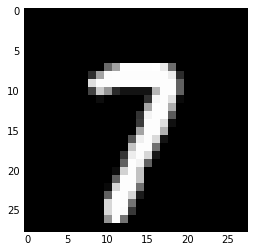

In [76]:
plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

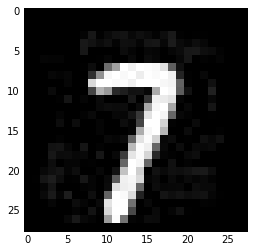

In [77]:
plt.imshow(((x_adv).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [102]:
w_curr[top_features_trial]/w_curr_mod

array([ 0.03330743,  0.02721327,  0.05327379, -0.03139813,  0.04233916,
        0.01152412, -0.00483536, -0.06544568,  0.06195552, -0.0477475 ,
       -0.01283811, -0.02134752, -0.0069735 ,  0.02203239,  0.00777793,
       -0.01435814,  0.02048689, -0.01693438,  0.02442649, -0.01059313,
        0.00797621,  0.04494698,  0.01796657, -0.0470796 ,  0.00589131,
       -0.0309924 , -0.04839097, -0.02211701,  0.0373928 , -0.08187933,
       -0.06878127,  0.03388841,  0.0684389 ,  0.04361412,  0.04905637,
        0.04769934,  0.02095824,  0.032821  , -0.03267438, -0.02404208,
       -0.04848121,  0.00826073, -0.02135739,  0.02305021, -0.02392234,
       -0.00890515,  0.0656329 , -0.05075111,  0.04243452,  0.01669917,
        0.02472155, -0.01079853,  0.03452073, -0.02733155,  0.02881062,
        0.07114636, -0.0180258 ,  0.01226024,  0.00664438,  0.02161624,
        0.0139223 ,  0.09637619,  0.016573  ,  0.00364878,  0.06794708,
       -0.05291991, -0.02340848,  0.00099728,  0.06019218,  0.02

In [80]:
w_curr[top_boundary]

array([ 1.47990742, -1.32819338,  1.24750271, -1.2053886 , -1.19809061,
        1.15335927, -1.11041698,  1.10601021,  1.07997268, -1.06970014,
       -1.05295084, -1.03851966, -1.01465404, -1.01424257, -1.01150344,
        1.00198758, -0.99897741, -0.98982748, -0.98745662,  0.97720593,
       -0.97171469, -0.96522935, -0.95939395,  0.9502518 , -0.939762  ,
        0.92731457, -0.92611048, -0.9100027 , -0.90865209, -0.90038751,
        0.8927847 , -0.88007083, -0.87781589, -0.87325365, -0.8594821 ,
       -0.85126903,  0.85014108, -0.84653843, -0.84322874, -0.84259472,
        0.8376284 , -0.83506911, -0.83141564, -0.81354617, -0.80600528,
       -0.79408379, -0.77817006,  0.7702067 , -0.7693941 ,  0.76745514,
       -0.76607466, -0.75377848,  0.75229658,  0.7442069 , -0.74399631,
        0.74321289,  0.73968237, -0.73892364,  0.72073123, -0.71509332,
        0.71153388, -0.70774589,  0.70642062, -0.70448791, -0.69136355,
       -0.68489651,  0.68236089, -0.68041452, -0.67847133, -0.67

In [97]:
count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
count_correct=0.0
print_flag=0
alpha=1.0
beta=0.4
for i in range(10276):
    x_ini=(X_train_3_7[i,:]).reshape((1,784))
    ini_class=clf.predict(x_ini)
    delta_x=np.zeros((784))
    w_curr_mod=np.linalg.norm(w_curr)
    delta_x[top_features_trial]=alpha*(w_curr[top_features_trial]/w_curr_mod)
    #delta_x[top_features_diff]=-1
    mask = np.ones(784, dtype=bool)
    mask[top_features_trial] = False
    delta_x[mask]=beta*(w_curr[mask]/w_curr_mod)
    if clf.decision_function(x_ini)>0:
        x_adv_new=x_ini-delta_x
    elif clf.decision_function(x_ini)<0:
        x_adv_new=x_ini+delta_x
    #x_adv=(x_ini-1.0*(clf.coef_[ini_class[0],:]/(np.linalg.norm(clf.coef_[ini_class[0],:])))).reshape((1,784))
    X_adv_new[i,:]=x_adv_new
    #x_adv=adv_x[i,:].reshape((1,784))
    final_class=clf.predict(x_adv_new)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if y_train_3_7[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if y_train_3_7[i]!=final_class[0] and ini_class[0]==y_train_3_7[i]:
        count_pure_adv=count_pure_adv+1
    if ini_class[0]==y_train_3_7[i]:
        count_correct=count_correct+1
#     if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
#         #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
#         #plt.imshow(((x_adv).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
#         print_flag=print_flag+1
print count_wrong/10276.0, count_adv/10276.0, count_pure_adv/count_correct
print np.sqrt((np.linalg.norm(delta_x)**2)/784)

0.634974698326 0.637407551576 0.636523266023
0.0186023416524


In [92]:
rd_2=40
pca_2=PCA(n_components=rd_2)
pca_2.fit(X_train_3_7)
X_train_dr=pca_2.transform(X_train_3_7).reshape((10276,rd_2))
X_test_dr=pca_2.transform(X_test_3_7).reshape((2038,rd_2))
#X_val_dr=pca_2.transform(PCA_in_val).reshape((10000,rd_2))
#X_adv_dr_test=pca_2.transform(adv_x_test).reshape((10000,rd_2))
clf_pca=svm.LinearSVC(dual=False)
clf_pca.fit(X_train_dr,y_train_3_7)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [94]:
clf_pca.score(X_test_dr,y_test[indices_3_7_test])

0.97791952894995093

In [98]:
X_adv_dr=pca_2.transform(X_adv).reshape((10276,rd_2))
X_adv_new_dr=pca_2.transform(X_adv_new).reshape((10276,rd_2))

In [109]:
count_pure_adv_pca=0.0
count_adv_pca=0.0
count_wrong_pca=0.0
#print_flag_pca=0
for i in range(10276):
    x_ini=(X_train_dr[i,:]).reshape((1,rd_2))
    ini_class=clf_pca.predict(x_ini)
    #x_adv=(x_ini-1.0*(clf_pca.coef_[ini_class[0],:]/(np.linalg.norm(clf_pca.coef_[ini_class[0],:])))).reshape((1,rd_2))
    x_adv_new_dr=X_adv_new_dr[i,:].reshape((1,rd_2))
    final_class=clf_pca.predict(x_adv_new_dr)
    if ini_class[0]!=final_class[0]:
        count_adv_pca=count_adv_pca+1
    if y_train_3_7[i]!=final_class[0]:
        count_wrong_pca=count_wrong_pca+1
    if y_train_3_7[i]!=final_class[0] and ini_class[0]==y_train_3_7[i]:
        count_pure_adv_pca=count_pure_adv_pca+1
    if ini_class[0]==y_train_3_7[i]:
        count_correct=count_correct+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #print_flag=print_flag+1
print count_wrong_pca/10276.0, count_adv_pca/10276.0, count_pure_adv_pca/count_correct
print np.sqrt((np.linalg.norm(x_ini-x_adv_new_dr)**2)/rd_2)

0.0194628260023 0.00593616193071 0.00300877971787
0.0215875853326


In [110]:
count_pure_adv_pca=0.0
count_adv_pca=0.0
count_wrong_pca=0.0
#print_flag_pca=0
for i in range(10276):
    x_ini=(X_train_dr[i,:]).reshape((1,rd_2))
    ini_class=clf_pca.predict(x_ini)
    #x_adv=(x_ini-1.0*(clf_pca.coef_[ini_class[0],:]/(np.linalg.norm(clf_pca.coef_[ini_class[0],:])))).reshape((1,rd_2))
    x_adv_dr=X_adv_dr[i,:].reshape((1,rd_2))
    final_class=clf_pca.predict(x_adv_dr)
    if ini_class[0]!=final_class[0]:
        count_adv_pca=count_adv_pca+1
    if y_train_3_7[i]!=final_class[0]:
        count_wrong_pca=count_wrong_pca+1
    if y_train_3_7[i]!=final_class[0] and ini_class[0]==y_train_3_7[i]:
        count_pure_adv_pca=count_pure_adv_pca+1
    if ini_class[0]==y_train_3_7[i]:
        count_correct=count_correct+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #print_flag=print_flag+1
print count_wrong_pca/10276.0, count_adv_pca/10276.0, count_pure_adv_pca/count_correct
print np.sqrt((np.linalg.norm(x_ini-x_adv_dr)**2)/rd_2)

0.0200467107824 0.00652004671078 0.00220315017592
0.0221800250685


In [103]:
w_curr_pca=clf_pca.coef_[0]
w_curr_pca_norm=np.linalg.norm(w_curr_pca)

In [106]:
count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
count_correct=0.0
print_flag=0
DEV_MAG=0.5
for i in range(10276):
    x_ini=(X_train_dr[i,:]).reshape((1,rd_2))
    ini_class=clf_pca.predict(x_ini)
    if clf_pca.decision_function(x_ini)>0:
        x_adv=(x_ini-DEV_MAG*(w_curr_pca/(np.linalg.norm(w_curr_pca)))).reshape((1,rd_2))
    elif clf_pca.decision_function(x_ini)<0:
        x_adv=(x_ini+DEV_MAG*(w_curr_pca/(np.linalg.norm(w_curr_pca)))).reshape((1,rd_2))
    #X_adv[i,:]=x_adv
    #x_adv=adv_x[i,:].reshape((1,784))
    final_class=clf_pca.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if y_train_3_7[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if y_train_3_7[i]!=final_class[0] and ini_class[0]==y_train_3_7[i]:
        count_pure_adv=count_pure_adv+1
    if ini_class[0]==y_train_3_7[i]:
        count_correct=count_correct+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        print_flag=print_flag+1
print count_wrong/10276.0, count_adv/10276.0, count_pure_adv/count_correct
print np.sqrt((np.linalg.norm(DEV_MAG*(w_curr_pca/(np.linalg.norm(w_curr_pca))))**2)/rd_2)

0.0463215258856 0.049922148696 0.0419256190194
0.0790569415042


In [107]:
w_curr_pca_norm

1.2824484088711021

In [108]:
w_curr_mod

10.396629341273499